# Image Retrieval with Azure Computer Vision 4.0

In this notebook, we will build a basic image vector similarity search application using the Azure Computer Vision Image Retrieval APIs.

Azure Computer Vision provides two Image Retrieval APIs for vectorizing image and text queries: the **Vectorize Image API** and the **Vectorize Text API**. This vectorization converts images and text into coordinates in a 1024-dimensional vector space, enabling users to search a collection of images using text and/or images without the need for metadata, such as image tags, labels, or captions.

You can read my article [Image Vector Similarity Search with Azure Computer Vision and PostgreSQL](https://sfoteini.github.io/blog/image-vector-similarity-search-with-azure-computer-vision-and-postgresql) to learn more about image vector similarity search.

Image source: [Kaggle](https://www.kaggle.com/datasets/nitishabharathi/scene-classification)

## Import libraries

In [1]:
import os
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
import glob
import json
import pathlib
from azurecv import (image_embedding, text_embedding, get_cosine_similarity, 
                     get_image_embedding_multiprocessing, 
                     search_by_image, search_by_text)

## Load Azure Computer Vision Endpoint & Key

In [2]:
# Load environment variables
load_dotenv()
endpoint = os.getenv('CV_ENDPOINT') + "computervision/"
key = os.getenv('CV_KEY')

## Image and text embeddings

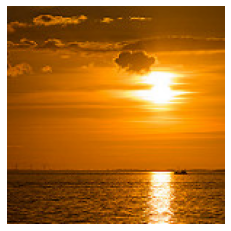

In [3]:
# image embedding
image = "images/image (18).jpg"
image_emb = image_embedding(image, endpoint, key)

# display the image
plt.imshow(Image.open(image))
plt.axis('off')
plt.show()

### Text-based image retrieval

In [4]:
txt = "sunset in the sea"
txt_emb = text_embedding(txt, endpoint, key)

In [5]:
cos_similarity = get_cosine_similarity(image_emb, txt_emb)
print(f"Cosine similarity: {cos_similarity}")

Cosine similarity: 0.3225007550881353


In [6]:
txt = "mountain peaks"
txt_emb = text_embedding(txt, endpoint, key)

In [7]:
cos_similarity = get_cosine_similarity(image_emb, txt_emb)
print(f"Cosine similarity: {cos_similarity}")

Cosine similarity: 0.15754042352674827


### Image-based image retrieval

In [8]:
# image embedding
img_mountains_1 = "images/image (4).jpg"
image_emb_1 = image_embedding(img_mountains_1, endpoint, key)
img_mountains_2 = "images/image (7).jpg"
image_emb_2 = image_embedding(img_mountains_2, endpoint, key)

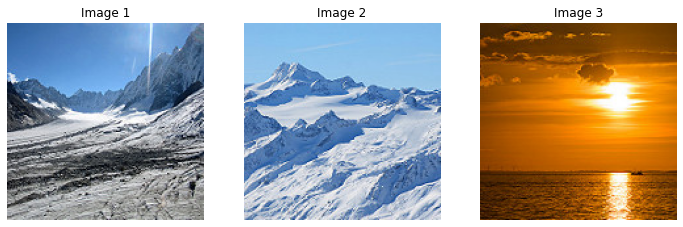

In [9]:
# display the 3 images
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
axes[0].imshow(Image.open(img_mountains_1))
axes[0].set_title("Image 1")
axes[0].axis('off')
axes[1].imshow(Image.open(img_mountains_2))
axes[1].set_title("Image 2")
axes[1].axis('off')
axes[2].imshow(Image.open(image))
axes[2].set_title("Image 3")
axes[2].axis('off')
plt.show()

In [10]:
print(f"Cosine similarity Image 1 and Image 2: {get_cosine_similarity(image_emb_1, image_emb_2)}")
print(f"Cosine similarity Image 1 and Image 3: {get_cosine_similarity(image_emb_1, image_emb)}")
print(f"Cosine similarity Image 2 and Image 3: {get_cosine_similarity(image_emb_2, image_emb)}")

Cosine similarity Image 1 and Image 2: 0.7436738639053782
Cosine similarity Image 1 and Image 3: 0.44542597784365107
Cosine similarity Image 2 and Image 3: 0.5179377503895738


## Generate embeddings for the image dataset

Using the Vectorize Image API, this code generates vector embeddings for 200 images and exports them into a JSON file.

In [11]:
images_folder = "images"
image_files = glob.glob(images_folder + "/*")

print(f"Total number of images: {len(image_files)}")

Total number of images: 200


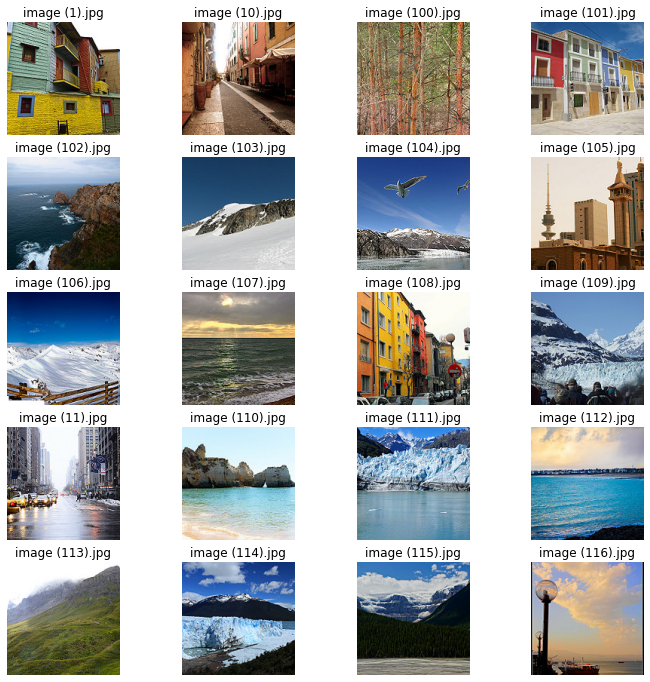

In [12]:
# display the images
nrows = 5
ncols = 4
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
for irow in range(nrows):
    for icol in range(ncols):
        axes[irow,icol].imshow(Image.open(image_files[ncols*irow + icol]))
        axes[irow,icol].set_title(f"{os.path.basename(image_files[ncols*irow + icol])}")
        axes[irow,icol].axis('off')
plt.show()

### Generate image embeddings

The `get_image_embedding_multiprocessing()` function is from Serge Retkowsky’s [Azure Computer Vision in a day workshop](https://github.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop).

In [13]:
print(f"Computing vector embeddings for {len(image_files)} images.")
image_embeddings = get_image_embedding_multiprocessing(image_files, endpoint, key, max_workers=4, max_attempts=20)
print("Done!")
print(f"Number of processed files: {len(image_files)}")
print(f"Number of vector embeddings generated: {len(image_embeddings)}")

Computing vector embeddings for 200 images.


100%|██████████| 200/200 [00:19<00:00, 10.10it/s]

Done!
Number of processed files: 200
Number of vector embeddings generated: 200


### Export image embeddings to JSON file

In [14]:
output_folder = "output"
pathlib.Path(output_folder).mkdir(parents=True, exist_ok=True)

In [15]:
emb_json = os.path.join(output_folder, "embeddings.json")

# Saving vectors embeddings into the json file
with open(emb_json, "w") as json_file:
    json.dump(image_embeddings, json_file)

print(f"Vector embeddings have been saved in: {emb_json}")

Vector embeddings have been saved in: output\embeddings.json


## Search by image or text prompt

Two image vector similarity search processes are highlighted: image-to-image search and text-to-image search.

* In the image-to-image search process, the reference image is converted into a vector embedding using the Vectorize Image API and the cosine distance is used to measure the similarity between the query vector and the vector embeddings of our image collection. The top matched images are retrieved and displayed alongside the reference image.

* In the text-to-image search process, the text query is converted into a vector embedding using the Vectorize Text API and the most similar images are retrieved and displayed based on the cosine similarity between the query vector and their vectors.

### Load embeddings and test images

In [16]:
emb_json = os.path.join(output_folder, "embeddings.json")

with open(emb_json) as f:
    image_embeddings = json.load(f)

print(f"Number of imported vector embeddings: {len(image_embeddings)}")

Number of imported vector embeddings: 200


In [17]:
test_folder = "test_images"
test_image_files = glob.glob(test_folder + "/*")

print(f"Total number of test images: {len(test_image_files)}")

Total number of test images: 6


### Test 1: Image-to-image search

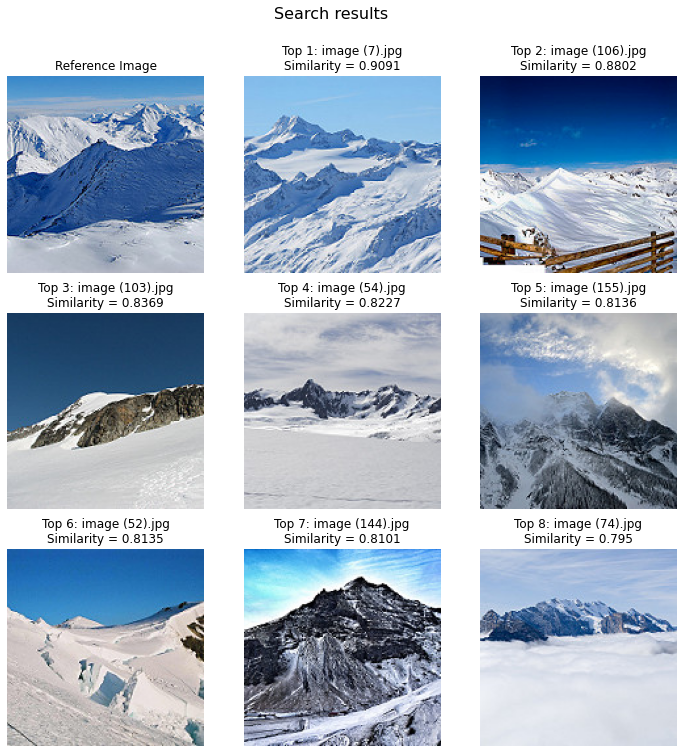

In [18]:
test_image = test_image_files[1]
df = search_by_image(test_image, image_files, image_embeddings, endpoint, key, topn=8, disp=True)

In [19]:
print("Similarity results:")
df.head(10)

Similarity results:


,image_file,similarity
167,images\image (7).jpg,0.909071
8,images\image (106).jpg,0.880209
5,images\image (103).jpg,0.836946
150,images\image (54).jpg,0.822727
62,images\image (155).jpg,0.813631
148,images\image (52).jpg,0.813482
50,images\image (144).jpg,0.810119
172,images\image (74).jpg,0.795006
156,images\image (6).jpg,0.788049
199,images\image (99).jpg,0.781270


### Test 2: Text-to-image search

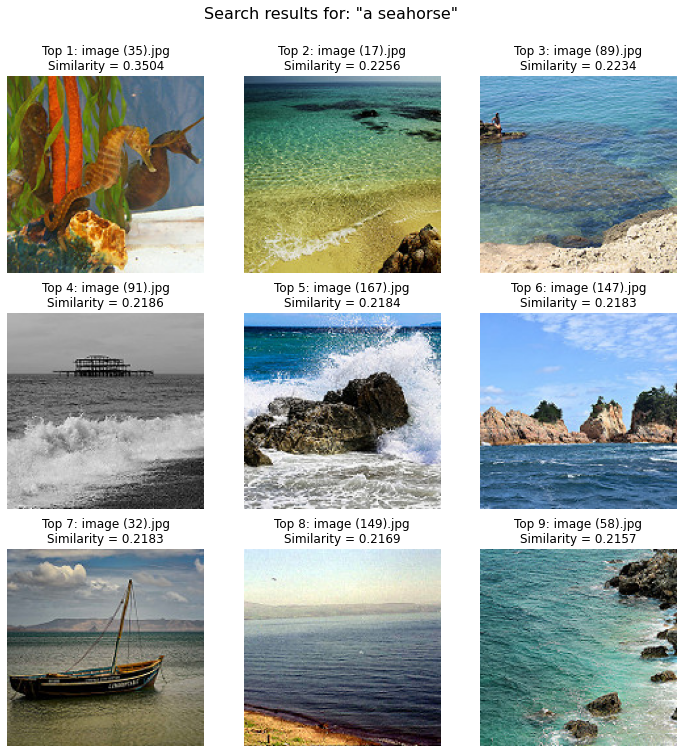

In [20]:
df_text = search_by_text('a seahorse', image_files, image_embeddings, endpoint, key, topn=9, disp=True)

In [21]:
print("Similarity results:")
df_text.head(10)

Similarity results:


,image_file,similarity
129,images\image (35).jpg,0.350393
78,images\image (17).jpg,0.225554
188,images\image (89).jpg,0.223435
191,images\image (91).jpg,0.218609
75,images\image (167).jpg,0.218425
53,images\image (147).jpg,0.218326
126,images\image (32).jpg,0.218254
55,images\image (149).jpg,0.216886
154,images\image (58).jpg,0.215702
124,images\image (30).jpg,0.215249
